In [1]:
#get the imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import inspect
import random
import os
from sklearn.neighbors import KDTree
import multiprocessing as mp
import gc
from sklearn.cluster import KMeans
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
#return keypoints from an image using SURF
def getSURFMatches(image,param):

    #use SURF to get set of keypoints and corresponding descriptors
    sift = cv2.xfeatures2d.SURF_create(param)
    kp1,des1 = sift.detectAndCompute(image,None)
    return kp1,des1

#returns set of keypoints from the set of images provided
def getRefSet(imageSet,param):
    
    pointsSet = []
    for img in imageSet:
        p,d = getSURFMatches(img,param)
        pointsSet += [d]
    return pointsSet

#returns a set of images present in a folder
def getImageSet(foldername):
    images = [cv2.imread(foldername + str(i)) for i in os.listdir(foldername)]
    return images

#computes the set of points in a query image that are less than an average distance from 
#the set of reference points
def getBestPoints(rpset,qpset):
    
    dists = []
    for q in qpset:
        sumn = np.sum(np.linalg.norm(rpset - q))
        dists += [sumn]
    
    avg = sum(dists)/len(dists)
    points = []
    for i,d in enumerate(dists):
        if d < avg:
            points += [qpset[i]]
            
    return points

#computes the set of stable points for as set of images using n-1 cross validation methods
def createTestSet(imageSet,param):
    
    #get total set of SURF points for all images
    totalPset = getRefSet(imageSet,param)
    tsetPoints = []
    for i,qpset in enumerate(totalPset):
        #reference set
        rpset = np.concatenate(totalPset[0:i] + totalPset[i+1:])
        tsetPoints += [getBestPoints(rpset,qpset)]
        
    return np.concatenate(tsetPoints)
        

In [3]:
#computes the set of stable points for as set of images using n-1 cross validation methods
def createTestSet_Kmean(imageSet,param):
    
    #get total set of SURF points for all images
    totalPset = getRefSet(imageSet,param)
    tsetPoints = []
    rpset = np.concatenate(totalPset)
        
    return rpset

def get_Kmean(data,clusters = 100):
    estimator = KMeans(init='k-means++', n_clusters=clusters, n_init=10)
    y = estimator.fit(data)
    return y

def get_variance(data,clusters = 100):
    var = []
    for i in range(clusters):
        temp = data[data.iloc[:,-1]==i]
        mean = pd.DataFrame.mean(temp)
        var.append(np.mean((np.array(temp) - np.array(mean))**2))
    var = np.array(var)
    mean_var = np.mean(var)
    a = np.where(var < mean_var,1,0)
    var = var[a]
    ind = np.nonzero(a)
#     return np.array(var).argsort()[:int(clusters/2)]
    return var,ind

In [4]:
###Testing code for reference set generation
imageSet = getImageSet("./Dataset_4NSigComp2010/TrainingSet/Reference/")
refPoints = createTestSet(imageSet,400)

In [7]:
#test set using kmeans algorithm
test_set = createTestSet_Kmean(imageSet,400)

clusters = 100

y = get_Kmean(test_set,clusters)
cluster_centers = y.cluster_centers_
data = pd.DataFrame(test_set)
Y = pd.DataFrame(y.labels_)
#print (data.shape,Y.shape)
data = data.join(Y,how='left', lsuffix='_left', rsuffix='_right')

var,indexes = get_variance(data,clusters)

indexes

a = (np.isin(np.array(data)[:,-1], indexes))
ref_set = np.array(data)[a]
ref_set = ref_set[:,:-1]
cluster_centers = cluster_centers[indexes]

In [5]:
"""
Code for getting the stable points in an image (good points)

The algorithm is a nearest neighbour classification where each 
query point is compared with k nearest stable points. The distances 
are averaged and the resuting query point is termed as a good point 
if it lies within a threshold parameter.

The parameters to the system are :
theta : threshold to determine if the point is stable based on distances
K : the number of closest points to check (1 according to the paper)
refSet : the set of reference stable points represented as a KD-Tree 
param : Input to SURF to detect keypoints (400 acccording to the paper)

The function return the average distance of the closest k points 
averaged over the entire query set of points, the percentage of good points,
the number of good points and the total number of query points.
They are collectively henceforth referred to as the 'stats' for each invocation 
with a given set of params(theta value and k value).
"""

def get_good_points(image,theta,refSet,k=1,param=400):
    
    kp,ds = getSURFMatches(image,param)
    good = 0
    kAvgDist = 0
    for q in ds:
        dist,ind = refSet.query(q.reshape(1,-1),k)
        #print(dist)
        avgDist = sum(dist[0])/k
        #print(avgDist)
        kAvgDist += avgDist
        if avgDist < theta:
            good += 1
    
    return [kAvgDist/ds.shape[0]],good/ds.shape[0],good,ds.shape[0]

In [8]:
###Testing code for getting the good points in an image based on a reference set 
kdRefSet = KDTree(refPoints,leaf_size=40)
kdKmRefSet = KDTree(ref_set,leaf_size=40)
kdKmRefSet2 = KDTree(cluster_centers,leaf_size=50)
#genuine image set 
#genImage = getImageSet("./Dataset_4NSigComp2010/TrainingSet/Genuine/")
genImage = ["./Dataset_4NSigComp2010/TrainingSet/Genuine/" + str(image) \
             for image in os.listdir("./Dataset_4NSigComp2010/TrainingSet/Genuine/")]
#forged image set
#forgImage = getImageSet("./Dataset_4NSigComp2010/TrainingSet/Simulated/")
forgImage = ["./Dataset_4NSigComp2010/TrainingSet/Simulated/" + str(image) \
             for image in os.listdir("./Dataset_4NSigComp2010/TrainingSet/Simulated/")]

#disguised images
disImage = ["./Dataset_4NSigComp2010/TrainingSet/Disguise/" + str(image) \
             for image in os.listdir("./Dataset_4NSigComp2010/TrainingSet/Disguise/")]


In [10]:
#return the stats for a set fo images based on the params, 
#the last two params can be used for multithreded invocations and are not used here
def imageStats(imageSet,theta,refSet,k=1,param=400,resp = None,resa = []):
    
    stats = []
    for i in imageSet:
        image = cv2.imread(i)
        res = get_good_points(image,theta,kdRefSet,k,param)
        stats += [[res[0][0],res[1],res[2],res[3]]]
    
    if resp is not None:
        resa[resp] = stats
        
    return stats

In [11]:
#gets the stats for a range for threshold values 
def getStatsRangeTheta(imageSet,tStart,tEnd,tStep,refSet,k,param):
    
    total = int(round((tEnd - tStart)/tStep))
    tht = [tStart + i*tStep for i in range(total)]
    Pools = mp.Pool(mp.cpu_count())
    args = [(imageSet,theta,refSet,k,param) for theta in tht]
    #print(args)
    res = Pools.starmap(imageStats,args)
    return tht,res


In [ ]:
thts,g_res = getStatsRangeTheta(genImage,0.14,0.28,0.01,kdRefSet,1,400)
thts,f_res = getStatsRangeTheta(forgImage,0.14,0.28,0.01,kdRefSet,1,400)
thts,d_res = getStatsRangeTheta(disImage,0.14,0.28,0.01,kdRefSet,1,400)

g_res = np.array(g_res)
f_res = np.array(f_res)
d_res = np.array(d_res)

In [166]:
tdata = np.concatenate((g_res,f_res,d_res),axis=1)
tlabl = np.vstack((np.ones([g_res.shape[1],1],dtype=np.int)*1, \
                   np.ones([f_res.shape[1],1],dtype=np.int)*2, \
                   np.ones([d_res.shape[1],1],dtype=np.int)*3))

tlabl2 = np.array(['genuine']*g_res.shape[1] + ['forged']*f_res.shape[1] + ['disguised']*d_res.shape[1])

In [12]:
def trainSetPredictions(images,imageType,thts,p_threshold=0.75):
    
    lbls = np.unique(imageType)
    res = []  
    #print(images)
    for it,th in enumerate(thts):
        d = {}
        for l in lbls:
            
            temp = images[it][np.where(imageType == l)[0],1]
            
            true = np.sum(temp >= p_threshold)
            fals = temp.shape[0] - true
            d[l] = (true,fals)
        res += [(round(th,4),d)]
        
    return res

In [13]:
def rocPlot(results,trueLabel):
    
    x,y = [],[]
    for r in results:
        print("Threshold",r[0])
        print(r[1])
        tp,tn,fp,fn = 0,0,0,0
        for k in r[1].keys():
            if k == trueLabel:
                tp,fn = r[1][k][0],r[1][k][1]
            else:
                fp += r[1][k][0]
                tn += r[1][k][1]
        print("TRP",tp/(tp + fn),"FPR",fp/(tn + fp))
        print("------------------------------------")
        x += [tp/(tp + fn)]
        y += [fp/(tn + fp)]
        
    plt.figure(figsize=(10,8))
    plt.plot(y,x)
    plt.ylabel("True Positive Rate")
    plt.xlabel('False Positive Rate')
    plt.title("ROC curve for threshold range " + str(results[0][0]) + " - " + str(results[-1][0]) + " inclusive")
    plt.show()

In [199]:
res = trainSetPredictions(tdata,tlabl2,thts)

Threshold 0.14
{'disguised': (0, 20), 'forged': (0, 104), 'genuine': (0, 76)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.15
{'disguised': (0, 20), 'forged': (0, 104), 'genuine': (0, 76)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.16
{'disguised': (0, 20), 'forged': (0, 104), 'genuine': (0, 76)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.17
{'disguised': (0, 20), 'forged': (0, 104), 'genuine': (0, 76)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.18
{'disguised': (0, 20), 'forged': (0, 104), 'genuine': (0, 76)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.19
{'disguised': (0, 20), 'forged': (0, 104), 'genuine': (0, 76)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.2
{'disguised': (0, 20), 'forged': (1, 103), 'genuine': (5, 71)}
TRP 0.06578947368421052 FPR 0.008064516129032258
------------------------------------
Threshold 0.21
{'disguised': (4, 16), 'forged': (12

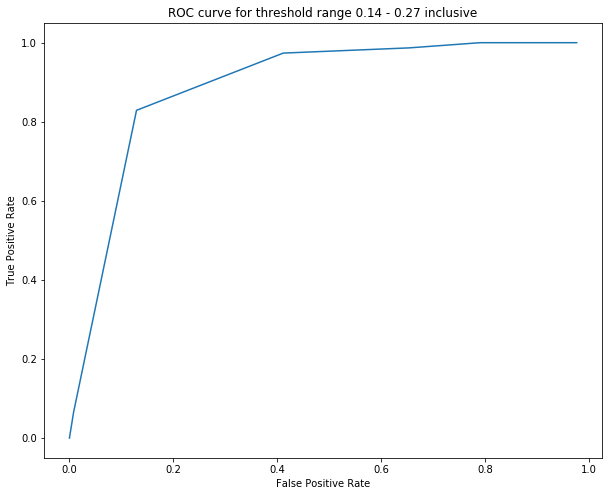

In [200]:
rocPlot(res,'genuine')

In [201]:
thts2,g_res2 = getStatsRangeTheta(genImage,0.2,0.23,0.002,kdRefSet,1,400)
thts2,f_res2 = getStatsRangeTheta(forgImage,0.2,0.23,0.002,kdRefSet,1,400)
thts2,d_res2 = getStatsRangeTheta(disImage,0.2,0.23,0.002,kdRefSet,1,400)

In [202]:
g_res2 = np.array(g_res2)
f_res2 = np.array(f_res2)
d_res2 = np.array(d_res2)
np.save("g_0.2_0.23_0.002_k1",g_res2)
np.save("f_0.2_0.23_0.002_k1",f_res2)
np.save("d_0.2_0.23_0.002_k1",d_res2)

In [ ]:
tdata2 = np.concatenate((g_res2,f_res2,d_res2),axis=1)
tlabl2_ = np.array(['genuine']*g_res2.shape[1] + ['forged']*f_res2.shape[1] + ['disguised']*d_res2.shape[1])

Threshold 0.2
{'disguised': (0, 20), 'forged': (1, 103), 'genuine': (5, 71)}
TRP 0.06578947368421052 FPR 0.008064516129032258
------------------------------------
Threshold 0.202
{'disguised': (0, 20), 'forged': (2, 102), 'genuine': (11, 65)}
TRP 0.14473684210526316 FPR 0.016129032258064516
------------------------------------
Threshold 0.204
{'disguised': (1, 19), 'forged': (6, 98), 'genuine': (29, 47)}
TRP 0.3815789473684211 FPR 0.056451612903225805
------------------------------------
Threshold 0.206
{'disguised': (1, 19), 'forged': (8, 96), 'genuine': (40, 36)}
TRP 0.5263157894736842 FPR 0.07258064516129033
------------------------------------
Threshold 0.208
{'disguised': (3, 17), 'forged': (11, 93), 'genuine': (48, 28)}
TRP 0.631578947368421 FPR 0.11290322580645161
------------------------------------
Threshold 0.21
{'disguised': (4, 16), 'forged': (12, 92), 'genuine': (63, 13)}
TRP 0.8289473684210527 FPR 0.12903225806451613
------------------------------------
Threshold 0.212
{'

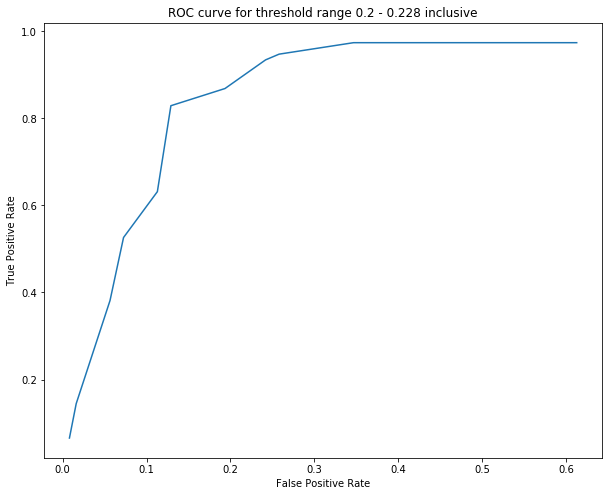

In [207]:
res = trainSetPredictions(tdata2,tlabl2_,thts2)
rocPlot(res,'genuine')

#### K-Testing

In [ ]:
g_res = []
f_res = []
d_res = []

for i in range(2,11,2):
    print(i)
    thts2,g_temp = getStatsRangeTheta(genImage,0.21,0.23,0.0025,kdRefSet,i,400)
    g_res.append(np.array(g_temp))
    print(g_res)
    thts2,f_temp = getStatsRangeTheta(forgImage,0.21,0.23,0.0025,kdRefSet,i,400)
    thts2,d_temp = getStatsRangeTheta(disImage,0.21,0.23,0.0025,kdRefSet,i,400)
    
    #g_res.append(np.array(g_temp))
    f_res.append(np.array(f_temp))
    d_res.append(np.array(d_temp))
    #print(g_res)

In [137]:
x = list(range(2,11,2))
tdata = []
for i,k in enumerate(x):
    np.save("g_" + str(k),g_res[i])
    np.save("f_" + str(k),f_res[i])
    np.save("d_" + str(k),d_res[i][j])
    tdata += [np.concatenate((g_res[i],f_res[i],d_res[i]),axis=1)]
    #tdata += [data]
    
tlabl2_ = np.array(['genuine']*g_res[0].shape[1] + ['forged']*f_res[0].shape[1] + ['disguised']*d_res[0].shape[1])

For K =  2
Threshold 0.21
{'genuine': (33, 43), 'disguised': (1, 19), 'forged': (5, 99)}
TRP 0.4342105263157895 FPR 0.04838709677419355
------------------------------------
Threshold 0.2125
{'genuine': (47, 29), 'disguised': (1, 19), 'forged': (10, 94)}
TRP 0.618421052631579 FPR 0.08870967741935484
------------------------------------
Threshold 0.215
{'genuine': (62, 14), 'disguised': (4, 16), 'forged': (13, 91)}
TRP 0.8157894736842105 FPR 0.13709677419354838
------------------------------------
Threshold 0.2175
{'genuine': (68, 8), 'disguised': (7, 13), 'forged': (18, 86)}
TRP 0.8947368421052632 FPR 0.20161290322580644
------------------------------------
Threshold 0.22
{'genuine': (72, 4), 'disguised': (9, 11), 'forged': (22, 82)}
TRP 0.9473684210526315 FPR 0.25
------------------------------------
Threshold 0.2225
{'genuine': (73, 3), 'disguised': (9, 11), 'forged': (32, 72)}
TRP 0.9605263157894737 FPR 0.33064516129032256
------------------------------------
Threshold 0.225
{'genuin

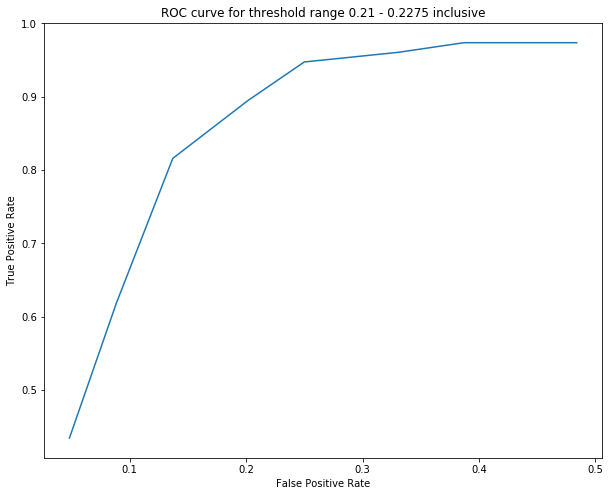

For K =  4
Threshold 0.21
{'genuine': (2, 74), 'disguised': (0, 20), 'forged': (0, 104)}
TRP 0.02631578947368421 FPR 0.0
------------------------------------
Threshold 0.2125
{'genuine': (5, 71), 'disguised': (0, 20), 'forged': (0, 104)}
TRP 0.06578947368421052 FPR 0.0
------------------------------------
Threshold 0.215
{'genuine': (16, 60), 'disguised': (0, 20), 'forged': (2, 102)}
TRP 0.21052631578947367 FPR 0.016129032258064516
------------------------------------
Threshold 0.2175
{'genuine': (37, 39), 'disguised': (1, 19), 'forged': (6, 98)}
TRP 0.4868421052631579 FPR 0.056451612903225805
------------------------------------
Threshold 0.22
{'genuine': (52, 24), 'disguised': (4, 16), 'forged': (10, 94)}
TRP 0.6842105263157895 FPR 0.11290322580645161
------------------------------------
Threshold 0.2225
{'genuine': (64, 12), 'disguised': (4, 16), 'forged': (16, 88)}
TRP 0.8421052631578947 FPR 0.16129032258064516
------------------------------------
Threshold 0.225
{'genuine': (68, 8

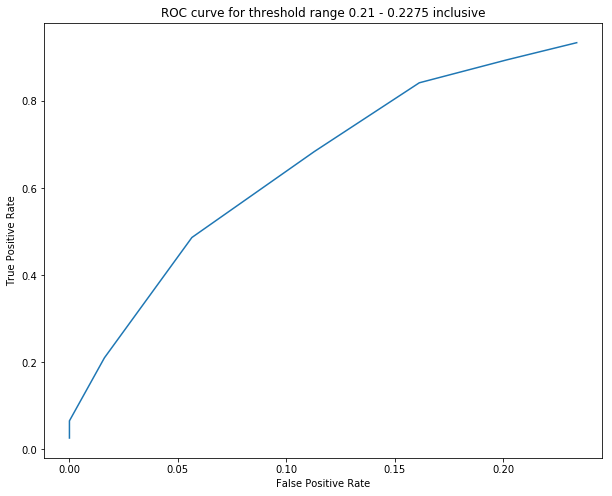

For K =  6
Threshold 0.21
{'genuine': (0, 76), 'disguised': (0, 20), 'forged': (0, 104)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.2125
{'genuine': (1, 75), 'disguised': (0, 20), 'forged': (0, 104)}
TRP 0.013157894736842105 FPR 0.0
------------------------------------
Threshold 0.215
{'genuine': (3, 73), 'disguised': (0, 20), 'forged': (0, 104)}
TRP 0.039473684210526314 FPR 0.0
------------------------------------
Threshold 0.2175
{'genuine': (10, 66), 'disguised': (0, 20), 'forged': (1, 103)}
TRP 0.13157894736842105 FPR 0.008064516129032258
------------------------------------
Threshold 0.22
{'genuine': (23, 53), 'disguised': (1, 19), 'forged': (2, 102)}
TRP 0.3026315789473684 FPR 0.024193548387096774
------------------------------------
Threshold 0.2225
{'genuine': (38, 38), 'disguised': (1, 19), 'forged': (7, 97)}
TRP 0.5 FPR 0.06451612903225806
------------------------------------
Threshold 0.225
{'genuine': (53, 23), 'disguised': (4, 16), 'forged': (11, 93)}

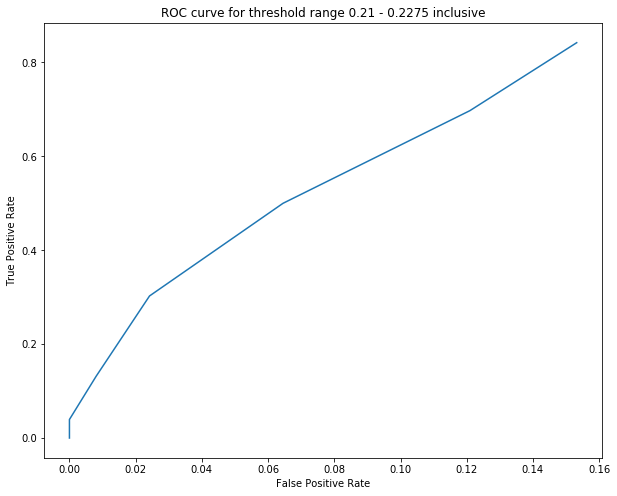

For K =  8
Threshold 0.21
{'genuine': (0, 76), 'disguised': (0, 20), 'forged': (0, 104)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.2125
{'genuine': (0, 76), 'disguised': (0, 20), 'forged': (0, 104)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.215
{'genuine': (1, 75), 'disguised': (0, 20), 'forged': (0, 104)}
TRP 0.013157894736842105 FPR 0.0
------------------------------------
Threshold 0.2175
{'genuine': (2, 74), 'disguised': (0, 20), 'forged': (0, 104)}
TRP 0.02631578947368421 FPR 0.0
------------------------------------
Threshold 0.22
{'genuine': (7, 69), 'disguised': (0, 20), 'forged': (0, 104)}
TRP 0.09210526315789473 FPR 0.0
------------------------------------
Threshold 0.2225
{'genuine': (18, 58), 'disguised': (1, 19), 'forged': (2, 102)}
TRP 0.23684210526315788 FPR 0.024193548387096774
------------------------------------
Threshold 0.225
{'genuine': (33, 43), 'disguised': (1, 19), 'forged': (5, 99)}
TRP 0.4342105263157895 FPR 0.04838

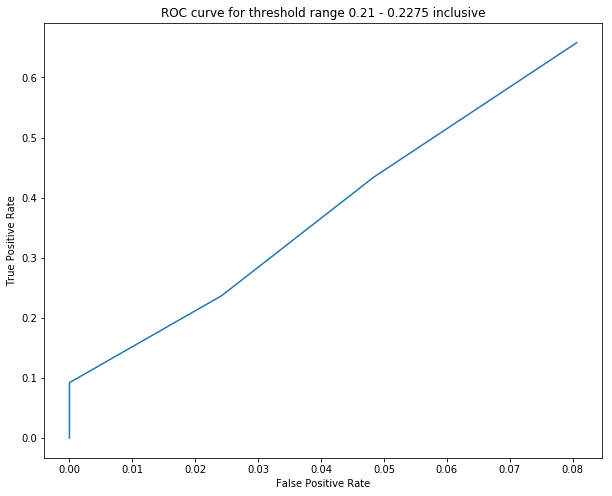

For K =  10
Threshold 0.21
{'genuine': (0, 76), 'disguised': (0, 20), 'forged': (0, 104)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.2125
{'genuine': (0, 76), 'disguised': (0, 20), 'forged': (0, 104)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.215
{'genuine': (0, 76), 'disguised': (0, 20), 'forged': (0, 104)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.2175
{'genuine': (1, 75), 'disguised': (0, 20), 'forged': (0, 104)}
TRP 0.013157894736842105 FPR 0.0
------------------------------------
Threshold 0.22
{'genuine': (3, 73), 'disguised': (0, 20), 'forged': (0, 104)}
TRP 0.039473684210526314 FPR 0.0
------------------------------------
Threshold 0.2225
{'genuine': (8, 68), 'disguised': (0, 20), 'forged': (0, 104)}
TRP 0.10526315789473684 FPR 0.0
------------------------------------
Threshold 0.225
{'genuine': (18, 58), 'disguised': (1, 19), 'forged': (1, 103)}
TRP 0.23684210526315788 FPR 0.016129032258064516
----------------

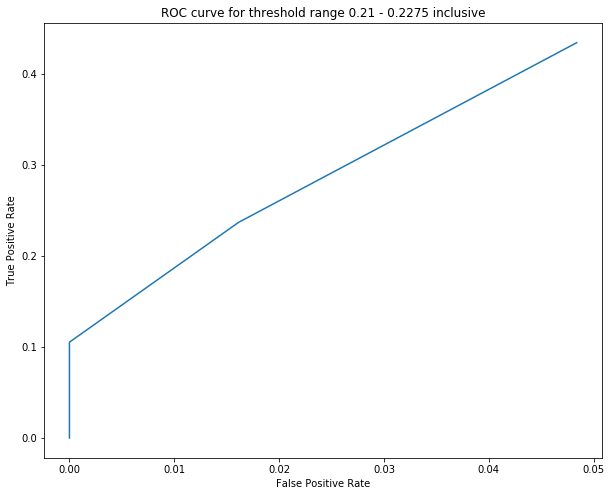

In [140]:
for i,k in enumerate(x):
    print("For K = ",k)
    res = trainSetPredictions(tdata[i],tlabl2_,thts2)
    rocPlot(res,'genuine')

In [ ]:
g_res = []
f_res = []
d_res = []

for i in range(2,11,2):
    print(i)
    thts2,g_temp = getStatsRangeTheta(genImage,0.21,0.25,0.0025,kdRefSet,i,400)
    g_res.append(np.array(g_temp))
    print(g_res)
    thts2,f_temp = getStatsRangeTheta(forgImage,0.21,0.25,0.0025,kdRefSet,i,400)
    thts2,d_temp = getStatsRangeTheta(disImage,0.21,0.25,0.0025,kdRefSet,i,400)
    
    #g_res.append(np.array(g_temp))
    f_res.append(np.array(f_temp))
    d_res.append(np.array(d_temp))
    #print(g_res)

## K-Means based Stable Points detection

In [ ]:
thts,g_res_km = getStatsRangeTheta(genImage,0.14,0.28,0.01,kdKmRefSet,4,400)
thts,f_res_km = getStatsRangeTheta(forgImage,0.14,0.28,0.01,kdKmRefSet,4,400)
thts,d_res_km = getStatsRangeTheta(disImage,0.14,0.28,0.01,kdKmRefSet,4,400)

g_res_km = np.array(g_res_km)
f_res_km = np.array(f_res_km)
d_res_km = np.array(d_res_km)

Threshold 0.14
{'genuine': (0, 76), 'disguised': (0, 20), 'forged': (0, 104)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.15
{'genuine': (0, 76), 'disguised': (0, 20), 'forged': (0, 104)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.16
{'genuine': (0, 76), 'disguised': (0, 20), 'forged': (0, 104)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.17
{'genuine': (0, 76), 'disguised': (0, 20), 'forged': (0, 104)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.18
{'genuine': (0, 76), 'disguised': (0, 20), 'forged': (0, 104)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.19
{'genuine': (0, 76), 'disguised': (0, 20), 'forged': (0, 104)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.2
{'genuine': (0, 76), 'disguised': (0, 20), 'forged': (0, 104)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.21
{'genuine': (2, 74), 'disguised': (0, 20), 'forged': (0, 104)}
TRP 0.

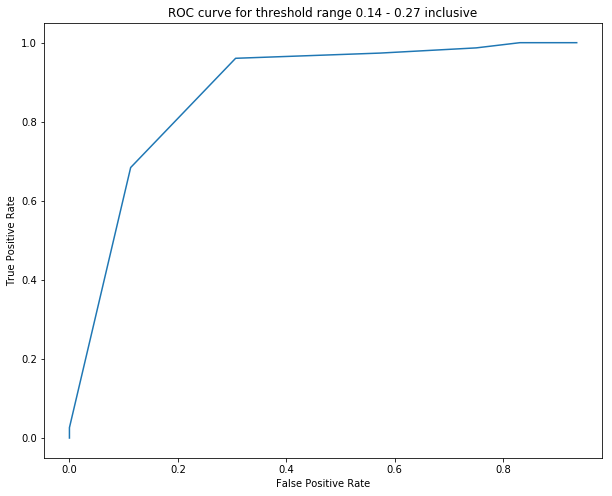

In [152]:
tdata = np.concatenate((g_res_km,f_res_km,d_res_km),axis=1)
res = trainSetPredictions(tdata,tlabl2_,thts)
rocPlot(res,'genuine')

Threshold 0.22
{'genuine': (52, 24), 'forged': (10, 94), 'disguised': (4, 16)}
TRP 0.6842105263157895 FPR 0.11290322580645161
------------------------------------
Threshold 0.2225
{'genuine': (64, 12), 'forged': (16, 88), 'disguised': (4, 16)}
TRP 0.8421052631578947 FPR 0.16129032258064516
------------------------------------
Threshold 0.225
{'genuine': (68, 8), 'forged': (17, 87), 'disguised': (8, 12)}
TRP 0.8947368421052632 FPR 0.20161290322580644
------------------------------------
Threshold 0.2275
{'genuine': (71, 5), 'forged': (21, 83), 'disguised': (8, 12)}
TRP 0.9342105263157895 FPR 0.23387096774193547
------------------------------------
Threshold 0.23
{'genuine': (73, 3), 'forged': (29, 75), 'disguised': (9, 11)}
TRP 0.9605263157894737 FPR 0.3064516129032258
------------------------------------
Threshold 0.2325
{'genuine': (74, 2), 'forged': (40, 64), 'disguised': (9, 11)}
TRP 0.9736842105263158 FPR 0.3951612903225806
------------------------------------
Threshold 0.235
{'gen

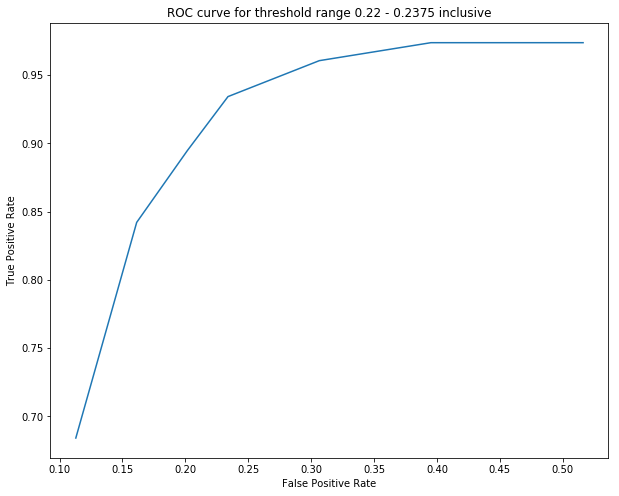

In [15]:
thts,g_res_km = getStatsRangeTheta(genImage,0.22,0.24,0.0025,kdKmRefSet,4,400)
thts,f_res_km = getStatsRangeTheta(forgImage,0.22,0.24,0.0025,kdKmRefSet,4,400)
thts,d_res_km = getStatsRangeTheta(disImage,0.22,0.24,0.0025,kdKmRefSet,4,400)

g_res_km = np.array(g_res_km)
f_res_km = np.array(f_res_km)
d_res_km = np.array(d_res_km)

tdata = np.concatenate((g_res_km,f_res_km,d_res_km),axis=1)
tlabl2_ = np.array(['genuine']*g_res_km.shape[1] + ['forged']*f_res_km.shape[1] + ['disguised']*d_res_km.shape[1])
res = trainSetPredictions(tdata,tlabl2_,thts)
rocPlot(res,'genuine')

Threshold 0.14
{'genuine': (0, 76), 'forged': (0, 104), 'disguised': (0, 20)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.15
{'genuine': (0, 76), 'forged': (0, 104), 'disguised': (0, 20)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.16
{'genuine': (0, 76), 'forged': (0, 104), 'disguised': (0, 20)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.17
{'genuine': (0, 76), 'forged': (0, 104), 'disguised': (0, 20)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.18
{'genuine': (0, 76), 'forged': (0, 104), 'disguised': (0, 20)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.19
{'genuine': (0, 76), 'forged': (0, 104), 'disguised': (0, 20)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.2
{'genuine': (0, 76), 'forged': (0, 104), 'disguised': (0, 20)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.21
{'genuine': (2, 74), 'forged': (0, 104), 'disguised': (0, 20)}
TRP 0.

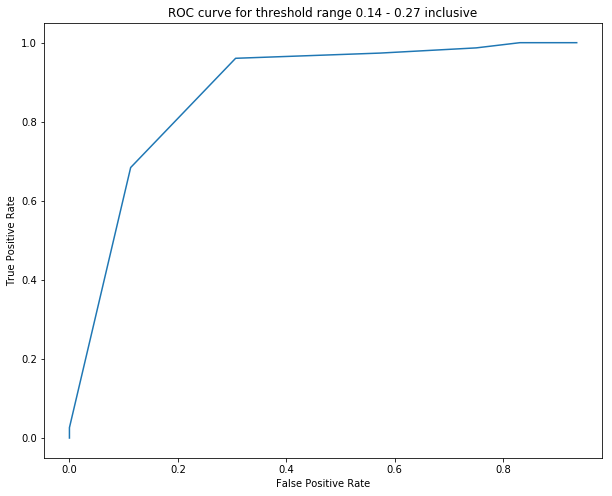

In [16]:
thts,g_res_km2 = getStatsRangeTheta(genImage,0.14,0.28,0.01,kdKmRefSet2,4,400)
thts,f_res_km2 = getStatsRangeTheta(forgImage,0.14,0.28,0.01,kdKmRefSet2,4,400)
thts,d_res_km2 = getStatsRangeTheta(disImage,0.14,0.28,0.01,kdKmRefSet2,4,400)

g_res_km2 = np.array(g_res_km2)
f_res_km2 = np.array(f_res_km2)
d_res_km2 = np.array(d_res_km2)

tdata = np.concatenate((g_res_km2,f_res_km2,d_res_km2),axis=1)
tlabl2_ = np.array(['genuine']*g_res_km.shape[1] + ['forged']*f_res_km.shape[1] + ['disguised']*d_res_km.shape[1])
res = trainSetPredictions(tdata,tlabl2_,thts)
rocPlot(res,'genuine')

Threshold 0.22
{'genuine': (52, 24), 'disguised': (4, 16), 'forged': (10, 94)}
TRP 0.6842105263157895 FPR 0.11290322580645161
------------------------------------
Threshold 0.2225
{'genuine': (64, 12), 'disguised': (4, 16), 'forged': (16, 88)}
TRP 0.8421052631578947 FPR 0.16129032258064516
------------------------------------
Threshold 0.225
{'genuine': (68, 8), 'disguised': (8, 12), 'forged': (17, 87)}
TRP 0.8947368421052632 FPR 0.20161290322580644
------------------------------------
Threshold 0.2275
{'genuine': (71, 5), 'disguised': (8, 12), 'forged': (21, 83)}
TRP 0.9342105263157895 FPR 0.23387096774193547
------------------------------------
Threshold 0.23
{'genuine': (73, 3), 'disguised': (9, 11), 'forged': (29, 75)}
TRP 0.9605263157894737 FPR 0.3064516129032258
------------------------------------
Threshold 0.2325
{'genuine': (74, 2), 'disguised': (9, 11), 'forged': (40, 64)}
TRP 0.9736842105263158 FPR 0.3951612903225806
------------------------------------
Threshold 0.235
{'gen

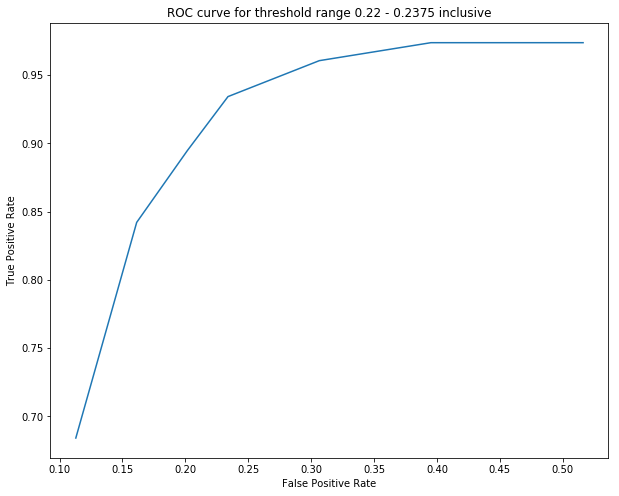

In [171]:
thts,g_res_km2 = getStatsRangeTheta(genImage,0.22,0.24,0.0025,kdKmRefSet2,4,400)
thts,f_res_km2 = getStatsRangeTheta(forgImage,0.22,0.24,0.0025,kdKmRefSet2,4,400)
thts,d_res_km2 = getStatsRangeTheta(disImage,0.22,0.24,0.0025,kdKmRefSet2,4,400)

g_res_km2 = np.array(g_res_km2)
f_res_km2 = np.array(f_res_km2)
d_res_km2 = np.array(d_res_km2)

tdata = np.concatenate((g_res_km2,f_res_km2,d_res_km2),axis=1)
tlabl2_ = np.array(['genuine']*g_res_km.shape[1] + ['forged']*f_res_km.shape[1] + ['disguised']*d_res_km.shape[1])
res = trainSetPredictions(tdata,tlabl2_,thts)
rocPlot(res,'genuine')